In [1]:
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from torchsummary import summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device, torch.get_num_threads()

/home/aiden/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


(device(type='cuda', index=0), 8)

#### Model

In [2]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(RNNModel,self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = torch.nn.Embedding(input_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size,
                    hidden_size,
                    num_layers,
                    batch_first=True,
                    bidirectional=False)
        self.linear = torch.nn.Linear(hidden_size, 64)
        self.linear64 = torch.nn.Linear(64, 2)
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.7)

    def init_hidden(self, batch_size):
        # (num_layers * num_directions, input_size, hidden_size)
        hidden = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)
        cell = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)
        return hidden, cell

        
    def forward(self, x):   
        embed = self.embed(x)
        
        hidden, cell = self.init_hidden(embed.size(0)) # initial hidden,cell
        output, (hidden, cell) = self.lstm(embed, (hidden, cell))
        
        hidden = hidden[-1:]
        hidden = torch.cat([h for h in hidden], 1)
        output = self.linear(hidden)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear64(output)
        return output

#### Dataset

In [4]:
# X = np.stack(df_model[:5000][fea_cols].values)

# embed = torch.nn.Embedding(input_size, 128).to(device)
# temp = torch.Tensor(X).long().to(device)
# X_embed = embed(temp)

# X_embed

class RNNDataset(Dataset):
    def __init__(self, df, y_col, col='text_idx'):
        self.col = col
        self.X = np.stack(df[self.col].values)
        self.y = pd.get_dummies(df[y_col].astype(int), prefix=y_col).values
        
#         self.embed = torch.nn.Embedding(input_size, embed_size)
        
    def __len__(self):
        return len(self.X)
    
    def get_feature_names(self):
        return [self.col]

    def __getitem__(self, idx):
        return self.X[idx].astype(np.int64), self.y[idx].astype(np.float32)
#         x = self.X[idx].astype(np.int64)
#         x = self.embed(torch.Tensor(x).long()).detach().numpy()
#         return x, self.y[idx].astype(np.float32)

#### eval_summary

In [5]:
def eval_summary(y_true, y_score, cut_off=0.5):
    if len(y_true) == 0 or len(y_score) == 0:
        return 'zero length'
    if len(y_true) != len(y_score):
        return 'diff length'
    
    y_pred = y_score.copy()
    y_pred[y_pred > cut_off] = 1
    y_pred[y_pred <= cut_off] = 0

    eval_dict = {}
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    
    eval_dict['auc'] = metrics.auc(fpr, tpr)
    eval_dict['confusion_matrix'] = metrics.confusion_matrix(y_true, y_pred)
    
    pre, rec, _, _ = metrics.precision_recall_fscore_support(y_true, y_pred, pos_label=1)
    eval_dict['precision'] = pre[1]
    eval_dict['recall'] = rec[1]
    
    return eval_dict

#### train/test_torch

In [6]:
from torch.utils.data import DataLoader
step = 64
num_workers = 8


def train_torch(dataset):
    model.train()
    loss = 0
    acc = 0
    data_loader = DataLoader(dataset=dataset,
#                           batch_size=100000,
#                         batch_size=int(train_size * 0.7),
                          batch_size=len(dataset) // step,
#                           batch_size=10000,
                          shuffle=True,
                          num_workers=num_workers,
                         drop_last=True
                         )
    for i, data in enumerate(data_loader):
#     for i, data in tqdm_notebook(enumerate(data_loader), total=len(data_loader), desc = 'data_loader'):
        X_batch, y_batch = data
    
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        
        loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += (y_pred.argmax(1) == y_batch.argmax(1)).sum().item()
        
        del X_batch, y_batch, y_pred
        gc.collect()

    return loss / len(dataset), acc / len(dataset)


def test_torch(dataset):
    model.eval()
    loss = 0
    acc = 0
    
    data_loader = DataLoader(dataset=dataset,
                          batch_size=len(dataset) // step,
                          shuffle=False,
                          num_workers=num_workers,
                          drop_last=True
                         ) 
    
    for i, data in enumerate(data_loader):
        X_batch, y_batch = data
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss += loss.item()
            acc += (y_pred.argmax(1) == y_batch.argmax(1)).sum().item()
            
            y_pred = torch.sigmoid(y_pred)
            
            del X_batch, y_batch, y_pred
            
    return loss / len(dataset), acc / len(dataset)


def pred_torch(dataset):
    model.eval()
    loss = 0
    acc = 0
    
    y_true_list = []
    y_score_list = []

    data_loader = DataLoader(dataset=dataset,
                          batch_size=len(dataset) // step,
                          shuffle=False,
                          num_workers=1,
                          drop_last=True
                         ) 
    
    for i, data in enumerate(data_loader):
        X_batch, y_batch = data
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_true = y_batch
        y_true_list.append(y_true[:, 1].cpu().detach().numpy())

        with torch.no_grad():
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss += loss.item()
            acc += (y_pred.argmax(1) == y_batch.argmax(1)).sum().item()
            
            y_pred = torch.sigmoid(y_pred)
            y_score_list.append(y_pred[:, 1].cpu().detach().numpy())
            
            del X_batch, y_batch, y_true, y_pred
            
    return loss / len(dataset), acc / len(dataset), np.concatenate(y_true_list, axis=0), np.concatenate(y_score_list, axis=0)


#### Load Data

In [7]:
merged_ts = '20200101T002838_100_24161'
train_path = 'data/df_merged_{}_train.pkl'.format(merged_ts)
test_path = 'data/df_merged_{}_test.pkl'.format(merged_ts)

df_model = joblib.load(train_path)  
df_model = df_model.reset_index()
print('model_set\n', df_model['smishing'].value_counts())
df_test = joblib.load(test_path) 

idx_cols = ['smishing', 'id', 'index']
fea_cols = 'nouns_{}_idx'.format(merged_ts.split('_')[1])
input_size = int(merged_ts.split('_')[-1])
input_size

model_set
 0    277242
1     18703
Name: smishing, dtype: int64


24161

In [8]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295945 entries, 0 to 295944
Data columns (total 3 columns):
id               295945 non-null int64
nouns_100_idx    295945 non-null object
smishing         295945 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.8+ MB


In [9]:
x_test = torch.Tensor(np.stack(df_test[fea_cols].values)).long().to(device)

In [10]:
# X = np.stack(df_model[:5000][fea_cols].values)

# len(X[0])

# temp = torch.Tensor(X).long().to(device)

# temp

# embed = torch.nn.Embedding(input_size, 128).to(device)
# X_embed = embed(temp)

# X_embed

#### Training

In [11]:
from torchtools import EarlyStopping

In [12]:
[df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

skf = StratifiedKFold(n_splits=3, random_state=8405)

for cv, index in enumerate(skf.split(df_model[fea_cols], df_model['smishing'])):
    train_index, valid_index = index
    
    print(len(train_index), len(valid_index))
    train_set = RNNDataset(df_model.loc[train_index, [fea_cols, 'smishing']], 'smishing', fea_cols)
    valid_set = RNNDataset(df_model.loc[valid_index, [fea_cols, 'smishing']], 'smishing', fea_cols)
    
    print('\nCV', cv)
    model = RNNModel(input_size=input_size, 
                     embed_size=256, 
                     hidden_size=128, 
                     num_layers=2).to(device)
#     model = LSTMModel(input_size=128, hidden_size=32, num_layers=1).to(device)
#     model = NNModel(input_size=input_size, dropout_probability=0.7).to(device)
#     model =  LRModel(input_size=input_size).to(device)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)

    epoch = 1
    if cv == 0:
#         print(summary(model, (input_size, )))
        print(model.train())
    
#     pos_weight = torch.Tensor([1., 10.,])
    pos_weight = torch.Tensor([1., 20.,])
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00025)

    model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')
    print(model_ts)
    print('Epoch:', epoch)

    N_EPOCHS = 50
    is_summary = True
    for e in tqdm_notebook(range(epoch, epoch + N_EPOCHS), total=N_EPOCHS, desc = 'CV {} Epoch'.format(cv)):
        start_time = time.time()
        
        train_loss, train_acc = train_torch(train_set)
        valid_loss, valid_acc = test_torch(valid_set)
        print('CV {} Epoch {}\n\tTrain loss: {}\tValid loss: {}\t{}'.format(cv, e, train_loss, valid_loss, train_loss / valid_loss))
        
        early_stopping(valid_loss, model)
        
        if early_stopping.counter == 0:
            if is_summary:
                _, _, y_true, y_score = pred_torch(valid_set)            
                print('\t', eval_summary(y_true, y_score, cut_off=0.5))
                is_summary = False
        else:
            is_summary = True
        
        if early_stopping.early_stop:
            print("\tEarly stopping epoch {}, valid loss {}".format(e, valid_loss))
            break
    
        epoch = e + 1
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
#     valid_set = RNNDataset(df_model.loc[valid_index,[fea_cols, 'smishing']], 'smishing')
    _, _, y_true, y_score = pred_torch(valid_set)            
    print('\t', eval_summary(y_true, y_score, cut_off=0.5))

#     train_set = RNNDataset(df_model.loc[train_index, [fea_cols, 'smishing']], 'smishing')
    _, _, y_true, y_score = pred_torch(train_set)            
    print('END CV {} eval summary (train)\n'.format(cv), eval_summary(y_true, y_score, cut_off=0.5))

    torch.save(model.state_dict(), 'model/{}_{}_{}.model'.format(model_ts, cv, epoch-1))
    
    model.eval()
    pred_col = 'smishing_{}'.format(cv)
    df_test[pred_col] = torch.sigmoid(model(x_test))[:, 1].cpu().detach().numpy()
    df_test[[pred_col]].to_csv('submit/{}_{}_nn.csv'.format(model_ts, pred_col), index=True)

197296 98649

CV 0
RNNModel(
  (embed): Embedding(24161, 256)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=64, bias=True)
  (linear64): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.7, inplace=False)
)
20200101T012844
Epoch: 1


CV 0 Epoch 1
	Train loss: 0.0278672743588686	Valid loss: 0.23335766792297363	0.11941871792078018
Validation loss decreased (inf --> 0.233358).  Saving model ...
	 {'auc': 0.9952483585121591, 'confusion_matrix': array([[90596,  1818],
       [  245,  5965]]), 'precision': 0.7664139791854041, 'recall': 0.9605475040257649}
CV 0 Epoch 2
	Train loss: 0.00479491613805294	Valid loss: 0.013228232972323895	0.3624759316444397
Validation loss decreased (0.233358 --> 0.013228).  Saving model ...
CV 0 Epoch 3
	Train loss: 0.002613573567941785	Valid loss: 0.013067252933979034	0.20000940561294556
Validation loss decreased (0.013228 --> 0.013067).  Saving model ...
CV 0 Epoch 4
	Train loss: 0.002473504049703479	Valid loss: 0.0028259081300348043	0.8752952814102173
Validation loss decreased (0.013067 --> 0.002826).  Saving model ...
CV 0 Epoch 5
	Train loss: 0.0006033224053680897	Valid loss: 0.0029189852066338062	0.20668908953666687
EarlyStopping counter: 1 out of 20
CV 0 Epoch 6
	Train loss: 0.00057378

CV 1 Epoch 1
	Train loss: 0.019042346626520157	Valid loss: 0.14439861476421356	0.1318734735250473
Validation loss decreased (inf --> 0.144399).  Saving model ...
	 {'auc': 0.9877564542141056, 'confusion_matrix': array([[85811,  6603],
       [   78,  6132]]), 'precision': 0.48150765606595997, 'recall': 0.9874396135265701}
CV 1 Epoch 2
	Train loss: 0.004971635062247515	Valid loss: 0.01519655529409647	0.32715538144111633
Validation loss decreased (0.144399 --> 0.015197).  Saving model ...
CV 1 Epoch 3
	Train loss: 0.0020300631877034903	Valid loss: 0.006386818829923868	0.3178520202636719
Validation loss decreased (0.015197 --> 0.006387).  Saving model ...
CV 1 Epoch 4
	Train loss: 0.0011337576434016228	Valid loss: 0.010285480879247189	0.11022894084453583
EarlyStopping counter: 1 out of 20
CV 1 Epoch 5
	Train loss: 0.0010679296683520079	Valid loss: 0.0030335166957229376	0.3520434498786926
Validation loss decreased (0.006387 --> 0.003034).  Saving model ...
	 {'auc': 0.9998369559554297, 'co

CV 2 Epoch 1
	Train loss: 0.020877288654446602	Valid loss: 0.04455934464931488	0.46852773427963257
Validation loss decreased (inf --> 0.044559).  Saving model ...
	 {'auc': 0.9865899584355886, 'confusion_matrix': array([[51326, 41070],
       [    1,  6227]]), 'precision': 0.13165739898936507, 'recall': 0.9998394348105331}
CV 2 Epoch 2
	Train loss: 0.00927262008190155	Valid loss: 0.010455254465341568	0.8868861198425293
Validation loss decreased (0.044559 --> 0.010455).  Saving model ...
CV 2 Epoch 3
	Train loss: 0.0036744349636137486	Valid loss: 0.005377007648348808	0.6833605766296387
Validation loss decreased (0.010455 --> 0.005377).  Saving model ...
CV 2 Epoch 4
	Train loss: 0.001875836169347167	Valid loss: 0.00536634586751461	0.3495555818080902
Validation loss decreased (0.005377 --> 0.005366).  Saving model ...
CV 2 Epoch 5
	Train loss: 0.0009689595899544656	Valid loss: 0.0028003344777971506	0.34601566195487976
Validation loss decreased (0.005366 --> 0.002800).  Saving model ...
C

#### Predict Train

0    184823
1         4
2         1
6         1
9     12419
dtype: int64

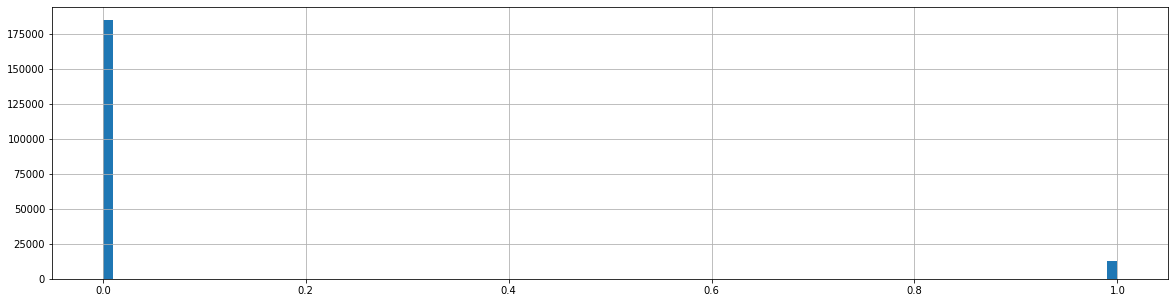

In [13]:
df = pd.Series(y_score)
df.hist(bins=100, figsize=(20, 5))
(df * 10).astype(int).value_counts(sort=False)

In [14]:
# df_model[(y_score <= 0.5) & (y_true == 1)]['text']

In [15]:
# df_model[(y_score > 0.5) & (y_true == 0)]['text']

#### Predict Test

In [16]:
pred_cols = [c for c in df_test.columns if 'smishing_' in c]
print(len(pred_cols))
df_test['pred_max'] = df_test[pred_cols].max(axis=1)
df_test['pred_min'] = df_test[pred_cols].min(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

df_test['smishing'] = df_test['pred_mean']

3
0.5772618055343628 0.00013806430797558278 0.028200680390000343


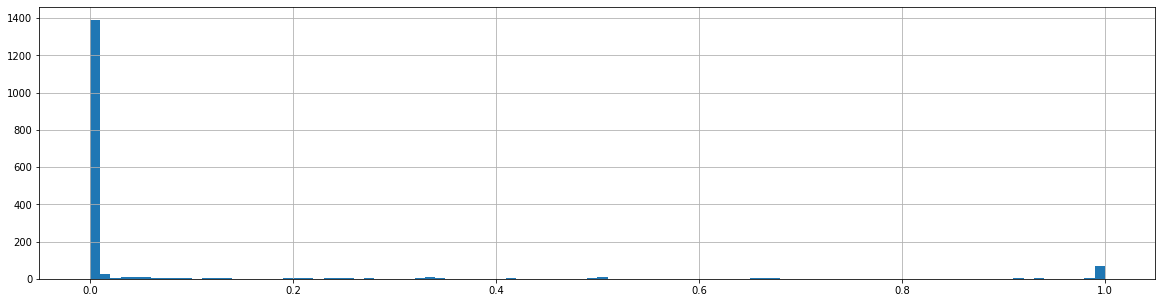

In [17]:
# df_test['smishing'] = torch.sigmoid(model(x_test))[:, 1].cpu().detach().numpy()
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [18]:
for c in pred_cols:
    print(c)
    display((df_test[c] * 10).astype(int).value_counts(sort=False))

smishing_0


0    1457
1      21
2      10
3       2
4       5
5      13
6       9
7      13
8       2
9      94
Name: smishing_0, dtype: int64

smishing_1


0    1494
1       4
2       1
3       1
4       1
6       1
7       4
8       1
9     119
Name: smishing_1, dtype: int64

smishing_2


0    1519
1       3
2       3
3       2
5       1
6       2
7       5
9      91
Name: smishing_2, dtype: int64

In [19]:
# 0     1504
# 1       11
# 2        6
# 3        6
# 4        2
# 5        3
# 6        2
# 9       39
# 10      53
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

0    1459
1      12
2      20
3      16
4       7
5       9
6      18
7       3
8       3
9      79
Name: smishing, dtype: int64

In [20]:
model_ts

'20200101T015403'

In [23]:
df_test[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)
# df_test[['id', 'smishing', 'text']].sort_values('smishing', ascending=False).to_csv('{}_text.csv'.format(model_ts), index=False)
